In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table as ApTable

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
# Load the data
_images = np.load("../data/test_sim/images_3.npz")
images = _images["images"]
# Don't forget to make sure that the images has odd columns and rows
images = deblender.nmf.reshape_img(images)
filters = _images["filters"]
_psfs = np.load("../data/test_sim/psfs.npz")
psfs = _psfs["psfs"]
if np.all(_psfs["filters"]!=filters):
    raise Exception("PSF and image filters do not match")
catalog = ApTable.read("../data/test_sim/true_catalog_3.fits")

In [3]:
# Load the files
filepath = os.path.join("/Users/fred/lsst/code/testdata_deblender/sim_data", "psf_matched_sim")
blend = 4

_images = np.load(os.path.join(filepath, "images_{0}.npz".format(blend)))
filters = _images["filters"]
images = _images["images"]
# Don't forget to make sure that the images has odd columns and rows
images = deblender.nmf.reshape_img(images)
_psfs = np.load(os.path.join(filepath, "psfs.npz"))
_filters = _psfs["filters"]
if np.all(_filters != filters):
    raise Exception("Filters indices did not match")
psfs = _psfs["psfs"]
catalog = ApTable.read(os.path.join(filepath, "true_catalog_{0}.fits".format(blend)))

In [4]:
_peaks = np.array([np.array(catalog["x"]), np.array(catalog["y"])]).T
# For now, only use a single component for each object
src_list = np.unique(catalog["index"])
peaks = np.zeros((len(src_list), 2))
for sid in src_list:
    src = catalog[catalog["index"]==sid][0]
    peaks[sid] = [src["x"], src["y"]]

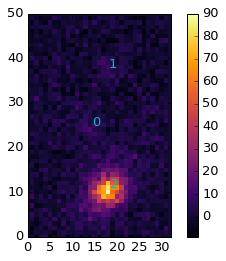

In [5]:
plt.imshow(images[0])
plt.colorbar()
for n, (px,py) in enumerate(peaks):
    plt.text(px, py, str(n), color='c')
plt.xlim([0,images[0].shape[1]-1])
plt.ylim([0, images[0].shape[0]-1])
plt.show()

In [6]:
l0_thresh = 1e-2

result = deblender.nmf.deblend(
    images,
    peaks=peaks,
    constraints="S",
    psf=None,
    max_iter=100,
    e_rel=1e-2,
    traceback=False,
    fit_positions=True,
    prox_S=deblender.proximal.strict_monotonicity(images, peaks=peaks, l0_thresh=l0_thresh),
)

INFO:proxmin.algorithms:Completed 101 iterations


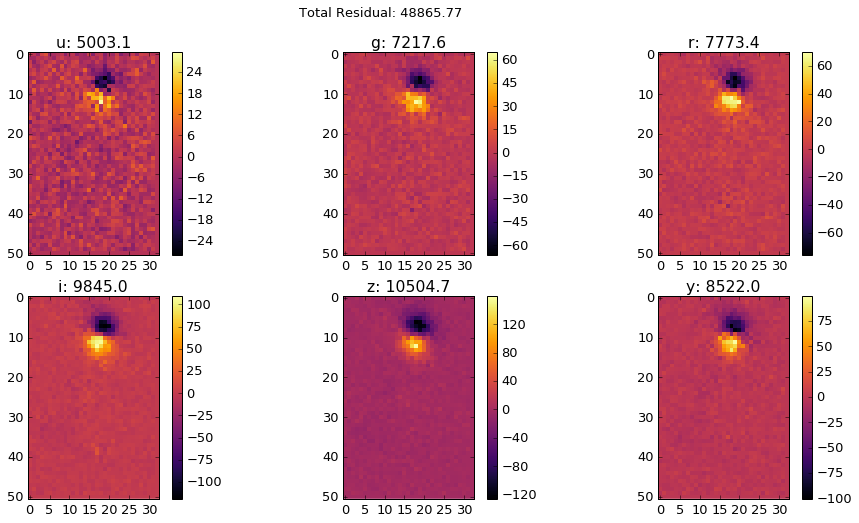

In [9]:
model = result.get_model(combine=True)
fig = plt.figure(figsize=(16,8))
ax = [fig.add_subplot(2,3,n+1) for n in range(len(model))]
for i in range(len(model)):
    ax_img = ax[i].imshow(result.img[i]-model[i])
    ax[i].set_title("{0}: {1:.1f}".format(filters[i], np.sum(np.abs(result.img[i]-model[i]))))
    fig.colorbar(ax_img, ax=ax[i])
fig.suptitle("Total Residual: {0:.2f}".format(np.sum(np.abs(result.img-model))))
plt.show()

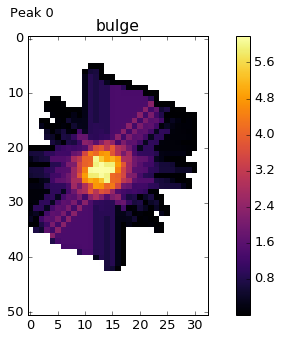

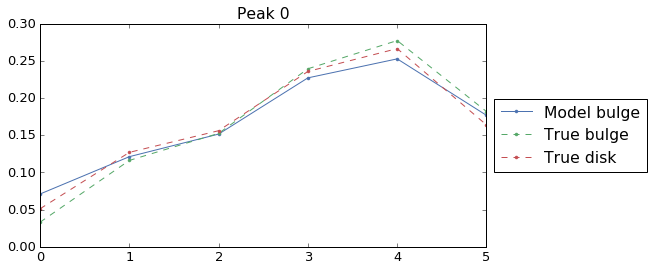

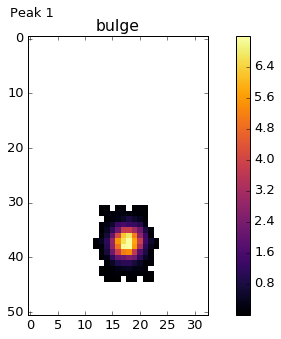

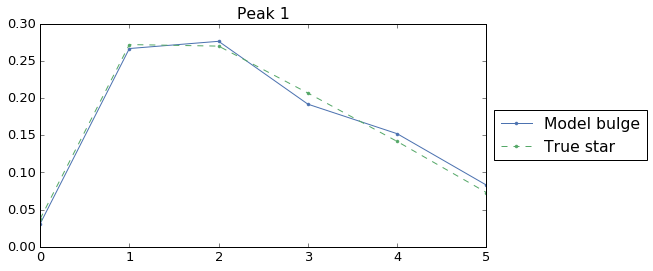

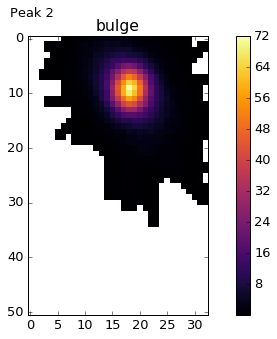

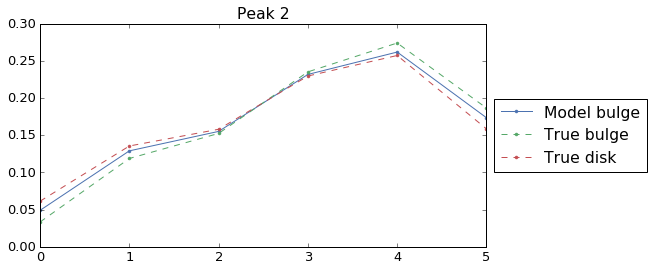

In [10]:
A, S, Gamma = result.A, result.S, result.T.Gamma

for sid in src_list:
    peak = result.T.peaks.peaks[sid]
    
    fig = plt.figure(figsize=(10,5))
    fig.suptitle("Peak {0}".format(sid))
    comps = len(peak.components)
    ax = []
    for n, (c, comp) in enumerate(peak.components.items()):
        k = comp.index
        ax.append(fig.add_subplot(1, comps, n+1))
        model = deblender.nmf.get_peak_model(A, S, Gamma, shape=(S[k].shape), k=k)[0]
        ax_img = ax[-1].imshow(np.ma.array(model, mask=model==0))
        fig.colorbar(ax_img, ax=ax[-1])
        ax[-1].set_title(comp.type)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.title("Peak {0}".format(sid))
    for c, comp in peak.components.items():
        k = comp.index
        plt.plot(A[:,k], '.-', label="Model {0}".format(comp.type))

    srcs = catalog[catalog["index"]==sid]
    for src in srcs:
        plt.plot(src["sed"], '.--', label="True {0}".format(src["component"]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()